In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import PIL
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

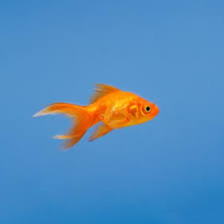

In [3]:
gold_fish = Image.open("download.jfif").resize(IMAGE_SHAPE)
gold_fish

In [4]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [5]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [6]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [7]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [8]:
image_labels[predicted_label_index]

'goldfish'

**Load flowers dataset**

In [9]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [10]:
data_dir

'./datasets/flower_photos'

In [11]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [12]:
list(data_dir.glob('*/*.jpg'))[:5]


[PosixPath('datasets/flower_photos/roses/14943194730_f48b4d4547_n.jpg'),
 PosixPath('datasets/flower_photos/roses/756943228_e15a7b2318.jpg'),
 PosixPath('datasets/flower_photos/roses/172311368_49412f881b.jpg'),
 PosixPath('datasets/flower_photos/roses/15712574834_2f121c7cf9_m.jpg'),
 PosixPath('datasets/flower_photos/roses/921984328_a60076f070_m.jpg')]

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [14]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/14943194730_f48b4d4547_n.jpg'),
 PosixPath('datasets/flower_photos/roses/756943228_e15a7b2318.jpg'),
 PosixPath('datasets/flower_photos/roses/172311368_49412f881b.jpg'),
 PosixPath('datasets/flower_photos/roses/15712574834_2f121c7cf9_m.jpg'),
 PosixPath('datasets/flower_photos/roses/921984328_a60076f070_m.jpg')]

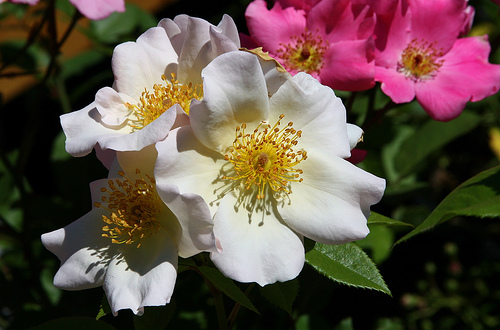

In [15]:
PIL.Image.open(str(roses[2]))


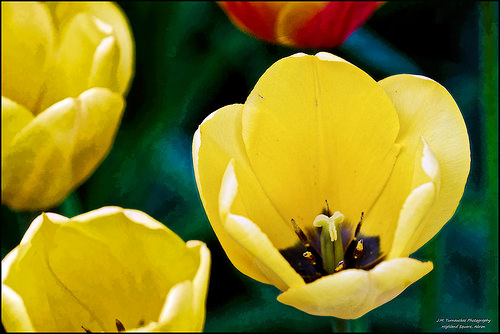

In [16]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [17]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [18]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [19]:
flowers_images_dict['roses'][:5]


[PosixPath('datasets/flower_photos/roses/14943194730_f48b4d4547_n.jpg'),
 PosixPath('datasets/flower_photos/roses/756943228_e15a7b2318.jpg'),
 PosixPath('datasets/flower_photos/roses/172311368_49412f881b.jpg'),
 PosixPath('datasets/flower_photos/roses/15712574834_2f121c7cf9_m.jpg'),
 PosixPath('datasets/flower_photos/roses/921984328_a60076f070_m.jpg')]

In [20]:
str(flowers_images_dict['roses'][0])


'datasets/flower_photos/roses/14943194730_f48b4d4547_n.jpg'

In [21]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))


In [22]:
img.shape


(213, 320, 3)

In [23]:
cv2.resize(img,(224,224)).shape


(224, 224, 3)

In [24]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [25]:
X = np.array(X)
y = np.array(y)

**Train test split**

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255


In [28]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

In [29]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

array([722, 722, 795])

In [30]:
image_labels[795]


'shower curtain'

**Now take pre-trained model and retrain it using flowers images**

In [31]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [32]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
86/86 [==============================] - 7s 41ms/step - loss: 0.7542 - acc: 0.7253
Epoch 2/10
86/86 [==============================] - 4s 41ms/step - loss: 0.4026 - acc: 0.8605
Epoch 3/10
86/86 [==============================] - 4s 41ms/step - loss: 0.3201 - acc: 0.8935
Epoch 4/10
86/86 [==============================] - 4s 41ms/step - loss: 0.2709 - acc: 0.9168
Epoch 5/10
86/86 [==============================] - 4s 43ms/step - loss: 0.2282 - acc: 0.9350
Epoch 6/10
86/86 [==============================] - 4s 42ms/step - loss: 0.1988 - acc: 0.9462
Epoch 7/10
86/86 [==============================] - 4s 41ms/step - loss: 0.1796 - acc: 0.9491
Epoch 8/10
86/86 [==============================] - 4s 41ms/step - loss: 0.1587 - acc: 0.9589
Epoch 9/10
86/86 [==============================] - 4s 41ms/step - loss: 0.1418 - acc: 0.9658
Epoch 10/10
86/86 [==============================] - 4s 41ms/step - loss: 0.1282 - acc: 0.9738


In [34]:
model.evaluate(X_test_scaled,y_test)


29/29 [==============================] - 3s 56ms/step - loss: 0.3580 - acc: 0.8758


[0.3579672574996948, 0.8758170008659363]